In [130]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prettytable as pt
import copy

# Лабораторная №2

### Линейная интерполяция

Коэффициенты: 2.9999969566309646x + -27.606307905254777


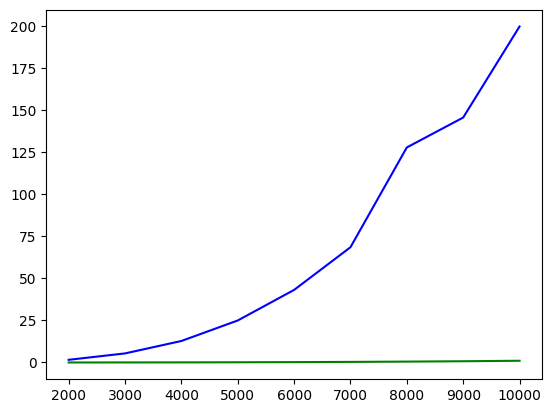

In [131]:
class Interpolation:

    def __init__(self, i = 1):
        
        self.koefs = None

        self.readCSV("table.csv", i)

        print(f"Коэффициенты: {self.koefs[0]}x + {self.koefs[1]}")

    def readCSV(self, fileName, i):
        
        df = pd.read_csv(fileName)

        x = np.log(df['t'].to_numpy())
        y = np.log(df[f'var{i}'].to_numpy())
        
        koefs = np.zeros((y.size - 1, 2))

        for i in range(1, y.size):
            koefs[i - 1, 0] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
            koefs[i - 1, 1] = y[i - 1] - koefs[i - 1, 0] * x[i - 1]

        self.koefs = [np.mean(koefs[:, 0]), 
                      np.mean(koefs[:, 1])]
    
    def graph(self, fileName = "table.csv"):

        df = pd.read_csv(fileName)

        x1 = df['t'].to_numpy()
        y1 = df[f'var{1}'].to_numpy()
        y2 = df[f'var{2}'].to_numpy()

        plt.plot(x1, y1, color = 'green')
        plt.plot(x1, y2, color = 'blue')

        plt.show()
        
    def getResult(self, x):
        x = np.log(x)
        
        return np.exp(self.koefs[0] * x + self.koefs[1])
    
interpol = Interpolation()
interpol.graph()

### Исходная система уравнений

In [132]:
class Equation:

    def __init__(self):
        self.R = 0.35
        self.Tw = 2000
        self.T0 = 1e4
        self.p = 4
        self.c = 3e10

        self.cur_z = -1
        
        self.interpolation = Interpolation()

    def T(self, z):
        return (self.Tw - self.T0) * z ** self.p + self.T0

    def u_p(self, z):
        return 3.084e-4 / (np.exp(4.799e4 / self.T(z)) - 1)

    def k(self, z):
        return self.interpolation.getResult(self.T(z))
    
    def dU(self, z, F):
        return -3 * self.R * self.k(z) * F / self.c
    
    def dF(self, z, u, F):

        part = self.c * self.k(z) * (self.u_p(z) - u) * self.R

        # if self.u_p(z) == u:
        #     print(z)

        if (z == 0): 
            return part / 2
        else:
            return part - F / z

### Решение системы ОДУ

In [133]:
class Solver:

    def __init__(self, system : Equation):
        
        self.N = 100

        z0 = 0
        zMax = 1

        self.z = np.linspace(z0, zMax, self.N)

        self.step = (zMax - z0) / self.N
        self.system = system

        self.Fmax = 0

    def psi(self, ksi):

        u, F = self.Adams(ksi)

        self.Fmax = max(F)

        return F[-1] - 0.393 * self.system.c * u[-1]
    
    # def f(self):

    #     ksi = np.linspace(0, 1, 200)
    #     psi = [self.psi(ksi[i]) for i in range(len(ksi))]
        
    #     plt.plot(ksi, psi)
    #     plt.show()

    def DichotomyMethod(self):

        delta = 1e-10

        ksi = [0, 1]
        psi = [self.psi(ksi[0]), self.psi(ksi[1])]

        old_ksi = []

        while (np.abs(ksi[0] - ksi[1]) > delta):

            old_ksi = copy.copy(ksi)

            cur_ksi = (ksi[0] + ksi[1]) / 2
            cur_psi = self.psi(cur_ksi)

            if cur_psi * psi[0] < 0:
                ksi[1] = cur_ksi
                psi[1] = cur_psi
            else:
                ksi[0] = cur_ksi
                psi[0] = cur_psi

        return old_ksi, *self.Adams(cur_ksi)
    
    def Adams(self, ksi):

        uRes = np.zeros((self.N,))
        FRes = np.zeros((self.N,))

        uRes[0] = ksi * self.system.u_p(0)

        for i in range(1, self.N):

            z = self.z[i - 1]

            k1 = self.step * self.system.dU(z, FRes[i - 1])
            l1 = self.step * self.system.dF(z, uRes[i - 1], FRes[i - 1])

            k2 = 0
            l2 = 0
            if i > 1:
                k2 = self.step * self.system.dU(self.z[i - 2], FRes[i - 2])
                l2 = self.step * self.system.dF(self.z[i - 2], uRes[i - 2], FRes[i - 2])

            k3 = 0
            l3 = 0
            if i > 2:
                k3 = self.step * self.system.dU(self.z[i - 3], FRes[i - 3])
                l3 = self.step * self.system.dF(self.z[i - 3], uRes[i - 3], FRes[i - 3])

            delta_u = (23 * k1 - 16 * k2 + 5 * k3) / 12
            delta_F = (23 * l1 - 16 * l2 + 5 * l3) / 12

            uRes[i] = uRes[i - 1] + delta_u
            FRes[i] = FRes[i - 1] + delta_F

        return uRes, FRes

    def RungeKutt2(self, ksi):

        halfStep = self.step / 2
        
        uRes = np.zeros((self.N,))
        FRes = np.zeros((self.N,))

        uRes[0] = ksi * self.system.u_p(0)

        for i in range(1, self.N):

            z = self.z[i - 1]

            k1 = self.system.dU(z, FRes[i - 1])
            l1 = self.system.dF(z, uRes[i - 1], FRes[i - 1])

            k2 = self.system.dU(z + halfStep, FRes[i - 1] + halfStep * l1)
            l2 = self.system.dF(z + halfStep, uRes[i - 1] + halfStep * k1, FRes[i - 1] + halfStep * l1)
            
            uRes[i] =  uRes[i - 1] + self.step * k2
            FRes[i] =  FRes[i - 1] + self.step * l2

        return uRes, FRes

    def RungeKutt4(self, ksi):

        halfStep = self.step / 2

        uRes = np.zeros((self.N,))
        FRes = np.zeros((self.N,))
        
        uRes[0] = ksi * self.system.u_p(0)

        for i in range(1, self.N):

            z = self.z[i - 1]

            k1 = self.system.dU(z, FRes[i - 1])
            l1 = self.system.dF(z, uRes[i - 1], FRes[i - 1])

            k2 = self.system.dU(z + halfStep, FRes[i - 1] + halfStep * l1)
            l2 = self.system.dF(z + halfStep, uRes[i - 1] + halfStep * k1, FRes[i - 1] + halfStep * l1)

            k3 = self.system.dU(z + halfStep, FRes[i - 1] + halfStep * l2)
            l3 = self.system.dF(z + halfStep, uRes[i - 1] + halfStep * k2, FRes[i - 1] + halfStep * l2)

            k4 = self.system.dU(z + self.step, FRes[i - 1] + self.step * l3)
            l4 = self.system.dF(z + self.step, uRes[i - 1] + self.step * k3, FRes[i - 1] + self.step * l3)

            uRes[i] =  uRes[i - 1] + self.step * (k1 + 2 * k2 + 2 * k3 + k4) / 6
            FRes[i] =  FRes[i - 1] + self.step * (l1 + 2 * l2 + 2 * l3 + l4) / 6

            # print((FRes[i] - FRes[i - 1]) / (self.z[i] - self.z[i - 1]))

        return uRes, FRes

### Результаты

In [134]:
eq = Equation()
solve = Solver(eq)

# u, F = solve.Adams(1)

ksi, u, F = solve.DichotomyMethod()

z = solve.z
k = eq.k(z)
u_p = eq.u_p(z)

Коэффициенты: 2.9999969566309646x + -27.606307905254777


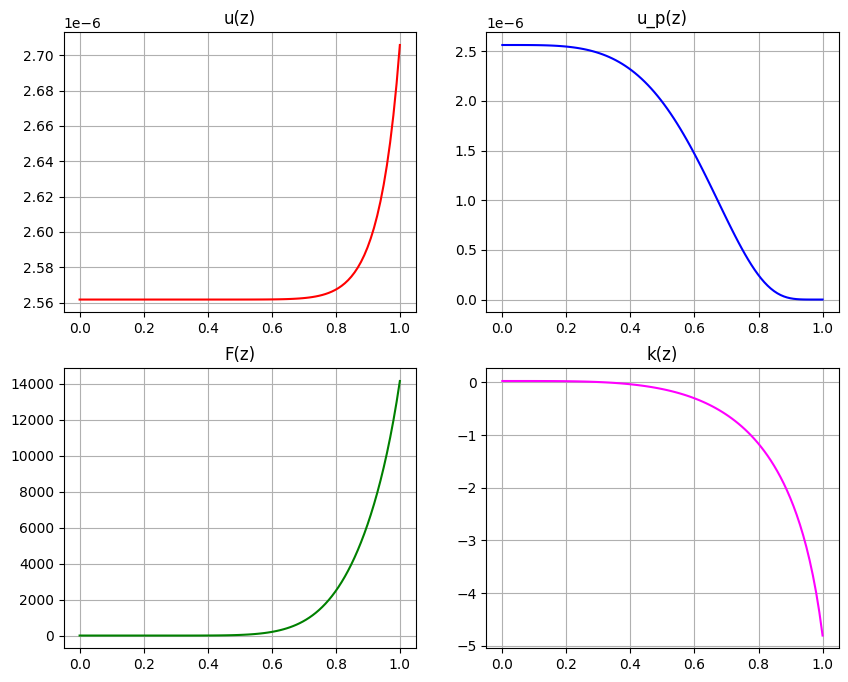

In [135]:
# Графики

fig, axs = plt.subplots(2, 2, figsize = (10, 8))

# u(z)
axs[0, 0].plot(z, u, "red")
axs[0, 0].set_title("u(z)")

# u_p(z)
# axs[0, 1].plot(z, u, "red")
axs[0, 1].plot(z, u_p, "blue")
axs[0, 1].set_title("u_p(z)")

# F(z)
axs[1, 0].plot(z, F, "green")
axs[1, 0].set_title("F(z)")

# k(z)
axs[1, 1].plot(z, k, "magenta")
axs[1, 1].set_title("k(z)")

for ax in axs.flat:
    ax.grid(True)

plt.show()

In [136]:
table = pt.PrettyTable()

table.add_column("z", np.round(z, 2))
table.add_column("u(z)", np.round(u, 10))
table.add_column("u_p(z)", np.round(u_p, 10))
table.add_column("F(z)", np.round(F, 4))
table.add_column("k(z)", np.round(k, 4))

table.border = True
ksi = np.sort(ksi)

print(f"Значение ξ: {(ksi[0] + ksi[1]) / 2}")
print(f"Границы ξ: ({ksi[0]}; {ksi[1]})")

Значение ξ: 0.9999999999417923
Границы ξ: (0.9999999998835847; 1.0)


# Лабораторная 3

In [53]:
# Метод прогонки решения слау в виде 3х диагональной матрицы
# Ax = F A - матрица

import numpy as np

A = np.array([[3, 1, 0],
              [-1, 4, 2],
              [0, 2, 3]])

f = np.array([1, -3, 5])

n = f.size

c = np.diag(A, k = -1)
d = np.diag(A, k = 0)
e = np.diag(A, k = 1)

a = np.zeros(n)
b = np.zeros(n)
x = np.zeros(n)

# прямой ход : находим прогоночные коэффициенты
for i in range(n - 1):

    if i == 0:
        a[i + 1] = -e[i] / d[i]
        b[i + 1] = f[i] / d[i]
    elif i != n:
        zn = c[i - 1] * a[i] + d[i]

        a[i + 1] = -e[i] / zn
        b[i + 1] = (f[i] - c[i - 1] * b[i]) / zn

# обратный ход : находим иксы
for i in range(n - 1, -1, -1):

    if i == n - 1:
        x[i] = (f[i] - c[i - 1] * b[i]) / (c[i - 1] * a[i] + d[i])
    else:   
        x[i] = a[i + 1] * x[i + 1] + b[i + 1]

print(x)

[ 1. -2.  3.]
